# Telecom Churn Case Study - Assignment
#### Shambhu Gupta/Abhishek Sathapadi [AIML CL13]

The Business Objective of this case study is to predict which customers are at high risk of churn based on the past data.
This case study is based on the Indian and Southeast Asian market for pre-aid mobile customers. This case study focuses 
on predictinmg the churn for high value customers (top 20%) only and to do that we will consider usage based churn data.

This solution is divided into the following sections: 
    
1. Data import and Data understanding
2. EDA and Data Cleaning
     - Impute missing with zeros
     - Remove columns that has single unique value
     - High Value Customer
     - Defining churn and tagging them in the data frame
     - Missing Value Treatment
     - Outliers detection and treatment
     - Doing Some Univariate Analysis
     - Doing Some Bi-variate Analysis
3. Derive New Features
4. Dimensionality reduction using PCA
5. Training various Model
    - Logistics Regression
    - SVM
    - Random Forest
6. Model Evaluation
7. Building the final optimum model
8. Suggesting ways to reducce customer churn

### 1. Data import and Data understanding
In this section, we will try to have a look at the dataset and understand the size, attribute names etc.

In [1]:
# Let's import all the relevant libraries at one place
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from scipy.stats import skew,norm
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the dataset
cust = pd.read_csv("telecom_churn_data.csv")
print("Dimenison of the dataset is:", cust.shape)
cust.head()

Dimenison of the dataset is: (99999, 226)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
print(cust.info())

# we can see there are ~ 100K entries in the data set. However, we have been asked to predict the churn onlky for high value
# customer. So, we will filter the dataset first before we could do any other data prep activity. 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None


In [4]:
# To check for empty strings exist in the dataframe
np.where(cust.applymap(lambda x: x == ' '))

(array([], dtype=int64), array([], dtype=int64))

In [5]:
# To check for percentage of missing values present in each column.
mv = round(100*(cust.isna().sum(axis=0)/cust.shape[0]), 2)
mv.loc[mv > 70]    # display only col. having more than 70% of missing value

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_8    73.66
date_of_last_rech_data_9    74.08
total_rech_data_6           74.85
total_rech_data_7           74.43
total_rech_data_8           73.66
total_rech_data_9           74.08
max_rech_data_6             74.85
max_rech_data_7             74.43
max_rech_data_8             73.66
max_rech_data_9             74.08
count_rech_2g_6             74.85
count_rech_2g_7             74.43
count_rech_2g_8             73.66
count_rech_2g_9             74.08
count_rech_3g_6             74.85
count_rech_3g_7             74.43
count_rech_3g_8             73.66
count_rech_3g_9             74.08
av_rech_amt_data_6          74.85
av_rech_amt_data_7          74.43
av_rech_amt_data_8          73.66
av_rech_amt_data_9          74.08
arpu_3g_6                   74.85
arpu_3g_7                   74.43
arpu_3g_8                   73.66
arpu_3g_9                   74.08
arpu_2g_6                   74.85
arpu_2g_7     

#### Observations from the Dataset 
- There are abbreviations in column names
- Data consists of 99,999 rows and 226 columns
- There are missing values in the dataset
- There are no empty strings in the dataset
- There are no misaligned columns
- No column names are missing
- There are no incorrect header or footer rows

### 2. EDA and Data Cleaning

#### i. Impute missing with zeros

In [6]:
# After investigating on the amount related columns we can impute zero values as they might not have done any recharge.
# To impute amount related columns having missing with zero
amtcols = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8","total_rech_data_9", "max_rech_data_6",
           "max_rech_data_7", "max_rech_data_8", "max_rech_data_9", "av_rech_amt_data_6", "av_rech_amt_data_7", 
           "av_rech_amt_data_8", "av_rech_amt_data_9"]
cust[amtcols] = cust[amtcols].fillna(0)

In [7]:
# To get the percentage of missing values in each column
mv = round(100*(cust.isna().sum(axis=0)/cust.shape[0]), 2)
mv.loc[mv > 0]

loc_og_t2o_mou               1.02
std_og_t2o_mou               1.02
loc_ic_t2o_mou               1.02
last_date_of_month_7         0.60
last_date_of_month_8         1.10
last_date_of_month_9         1.66
onnet_mou_6                  3.94
onnet_mou_7                  3.86
onnet_mou_8                  5.38
onnet_mou_9                  7.75
offnet_mou_6                 3.94
offnet_mou_7                 3.86
offnet_mou_8                 5.38
offnet_mou_9                 7.75
roam_ic_mou_6                3.94
roam_ic_mou_7                3.86
roam_ic_mou_8                5.38
roam_ic_mou_9                7.75
roam_og_mou_6                3.94
roam_og_mou_7                3.86
roam_og_mou_8                5.38
roam_og_mou_9                7.75
loc_og_t2t_mou_6             3.94
loc_og_t2t_mou_7             3.86
loc_og_t2t_mou_8             5.38
loc_og_t2t_mou_9             7.75
loc_og_t2m_mou_6             3.94
loc_og_t2m_mou_7             3.86
loc_og_t2m_mou_8             5.38
loc_og_t2m_mou

In [8]:
#To check the unique value counts
cust.fb_user_6.value_counts()

1.0    23000
0.0     2153
Name: fb_user_6, dtype: int64

**Note:** fb_user columns having only 2 values which are categorical in nature as fb user or not. So converting
          it to categorical dtype.

In [9]:
# First replace all nan values as some value like -1. This will help us to not lose any data
fb_cols = ["fb_user_6", "fb_user_7", "fb_user_8","fb_user_9"]
cust[fb_cols] = cust[fb_cols].fillna(-1)

# To convert fb user columns to categorical
cust.fb_user_6 = pd.Categorical(cust.fb_user_6)
cust.fb_user_7 = pd.Categorical(cust.fb_user_7)
cust.fb_user_8 = pd.Categorical(cust.fb_user_8)
cust.fb_user_9 = pd.Categorical(cust.fb_user_9)

In [10]:
# To check the value counts of night package users
cust.night_pck_user_6.value_counts()

0.0    24522
1.0      631
Name: night_pck_user_6, dtype: int64

**Note:** night_pck_user columns having only 2 values which are categorical in nature as fb user or not. So convert it to 
          categorical dtype.

In [11]:
# First replace all nan values as some value like -1
np_cols = ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8", "night_pck_user_9"]
cust[np_cols] = cust[np_cols].fillna(-1)

# To convert fb user columns to categorical
cust.night_pck_user_6 = pd.Categorical(cust.night_pck_user_6)
cust.night_pck_user_7 = pd.Categorical(cust.night_pck_user_7)
cust.night_pck_user_8 = pd.Categorical(cust.night_pck_user_8)
cust.night_pck_user_9 = pd.Categorical(cust.night_pck_user_9)


#### ii. Remove columns that has single unique value

In [12]:
# As observed, There are null values in most of the columns.Also observed that some of the columns have all zero values
# which will not add any value. Lets see no. of unique records for these columns and we can drop columns that have only 
# one value in it

print ("Columns that have all zero/blank/unique records are: ")
col_list = []
for col in cust.columns: 
    if (len(cust[col].unique()) <= 2):
        print(col)
        col_list.append(col)

Columns that have all zero/blank/unique records are: 
circle_id
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9


In [13]:
# We can drop above columns from the data frame as they dont add any value
# We can also delete mobile_number column as its unique for every row 

cust.drop(['mobile_number','circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 
                 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6',
                 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 
                 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'], axis=1, inplace=True)
print(cust.shape)
# We can observe that total columns has come down to 209

(99999, 209)


In [14]:
cust.info(verbose=all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 209 columns):
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
arpu_9                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
onnet_mou_9                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
offnet_mou_9                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_ic_mou_9               float64
roam_og_mou_6               float64
roam_og_mou_7               float64
roam_og_mou_8               float64
roam_og_mou_9               float64
loc_og_t2t_mou_6            float64
loc_og_t2t_mou_7            float64
loc_og_t2t_mou_8            float64
loc_og_t2t_mou_9            float64
loc_og_t2m_mou_6          

In [15]:
# After futher investigating we don't find any importance with the date columns so can be dropped.
date_cols = ['date_of_last_rech_6','date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']

cust.drop(columns=date_cols, axis=1, inplace=True)
cust.shape

(99999, 201)

#### iii. High Value Customer

We will now find the high value customer in this section based on business objectives:
    - only for pre-paid customer
    - consider only Usage based churn
    - We will consider June and July recharge amount and consider the top 70% customers only as high value customer

In [16]:
# Finding the High Value Customer as per above definition.
# There are two type of recharge - Data recharge and phone recharge
cust['AVG_amt_6_7'] = cust[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
cust.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,AVG_amt_6_7
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,...,1.0,1.0,1.0,-1.0,968,30.4,0.0,101.20,3.58,307.0
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,...,-1.0,1.0,1.0,-1.0,1006,0.0,0.0,0.00,0.00,229.0
2,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,...,-1.0,-1.0,-1.0,1.0,1103,0.0,0.0,4.17,0.00,241.5
3,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,...,-1.0,-1.0,-1.0,-1.0,2491,0.0,0.0,0.00,0.00,270.0
4,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,...,0.0,-1.0,-1.0,-1.0,1526,0.0,0.0,0.00,0.00,273.0


In [17]:
# To check the quantiles .25, .5 and .7 for 6,7 and average of 6,7 months
cust[['total_rech_amt_6','total_rech_amt_7','AVG_amt_6_7']].quantile([.25, .5, .70]) 

,total_rech_amt_6,total_rech_amt_7,AVG_amt_6_7
0.25,109.0,100.0,115.0
0.50,230.0,220.0,229.0
0.70,378.0,370.0,368.5


In [18]:
# Now, we will filter the dataframe where total recharge is more than 500
cust_new = cust[(cust['AVG_amt_6_7']> cust['AVG_amt_6_7'].quantile(0.7))]
# we got desired 29.9K customers now. However, we added one column, so lets drop that
cust_new.drop(['AVG_amt_6_7'], axis=1, inplace=True)
print(cust_new.shape)

(29979, 201)


So, we have got the high value customer now. We have ~ 29.9K customers that falls under this category. All our subsequent 
activities will be based on this data set.

#### iv. Defining churn and tagging them in the data frame
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

 - total_ic_mou_9
 - total_og_mou_9
 - vol_2g_mb_9
 - vol_3g_mb_9

In [19]:
# defining the churn condition
cond = ((cust_new['total_ic_mou_9'] == 0) | (cust_new['total_og_mou_9'] == 0))   \
         & ((cust_new['vol_2g_mb_9'] == 0) | (cust_new['vol_3g_mb_9'] == 0))

# creating churn variable.    1 implies churn and 0 as no churn
cust_new['churn'] = np.where(cond,1,0)

In [20]:
# To change the type of churn column to categorical type from int32
cust_new['churn'] = cust_new['churn'].astype('object')

In [21]:
# To check the value counts of churn and non-churn
print(cust_new.churn.value_counts())

# print churn ratio
print("Churn Ratio:")
print(cust_new.churn.value_counts()*100/cust_new.shape[0])

0    26936
1     3043
Name: churn, dtype: int64
Churn Ratio:
0    89.849561
1    10.150439
Name: churn, dtype: float64


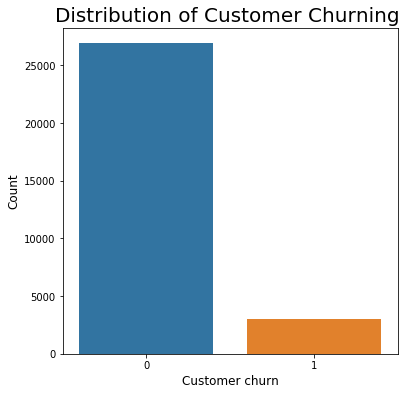

In [22]:
# Visualizing the churn distribution
plt.figure(figsize=(6,6))
sns.countplot(x = cust_new.churn)
plt.xlabel('Customer churn', fontsize= 12)
plt.ylabel('Count', fontsize= 12)
plt.title("Distribution of Customer Churning ",fontsize= 20)
plt.show()

# As we can see, there is a class imbalance, and we will take care of it later on

In [23]:
# To list the columns of churn phase
cols_9 = [col for col in cust_new.columns if '_9' in col]
print(cols_9)

# To drop all the columns of churn phase
cust_new.drop(columns=cols_9, axis=1, inplace=True)

# Data Frame Size after deleting this
print("\nDataFrame Shape is now:", cust_new.shape)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9']

DataFrame Shape is now: (29979, 153)


In [24]:
# To make copy of master dataset. All operation would be done on this pruned dataframe- churn_data
churn_data = cust_new.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis = 1, inplace=True)
churn_data.shape

(29979, 153)

#### v. Missing Value Treatment

We have 3 types of features in the given data. Date columns are dropped, categorical features are handled with -1 imputation and left with numerical features alone.

In [25]:
# To check for columns having more than 50% of missing.
mv1 = round(100*(churn_data.isnull().sum(axis=0)/churn_data.shape[0]), 2)
mv1.loc[mv1 > 50]

count_rech_2g_6    62.02
count_rech_2g_7    61.13
count_rech_2g_8    60.84
count_rech_3g_6    62.02
count_rech_3g_7    61.13
count_rech_3g_8    60.84
arpu_3g_6          62.02
arpu_3g_7          61.13
arpu_3g_8          60.84
arpu_2g_6          62.02
arpu_2g_7          61.13
arpu_2g_8          60.84
dtype: float64

In [26]:
# To drop columns having greater than 50% missing values
cols = ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']

churn_data.drop(columns=cols, axis=1, inplace=True)
churn_data.shape

(29979, 141)

In [27]:
# To get the list of columns having missing values
mv1 = round(100*(churn_data.isnull().sum(axis=0)/churn_data.shape[0]), 2)
s=mv1.loc[mv1>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [28]:
# Let us check by dropping rows of missing values
data = churn_data.dropna()
print(churn_data.shape[0]-data.shape[0])
# To delete the dataframe which is no more required
#del data   # Should be executed only once

1150


There is huge loss in the informaion if we drop rows of missing values.So we can try with any below options for imputation:
- Impute using native KNN from sklearn.impute package
- Impute using fancyimpute package. It has several algo (SimpleFill, KNN, SoftImpute, BiScaler,..) 

We will use KNN techniques to impute the mssing values. KNN is in memory operation and as we have ~ 29.9 K records,
it takes around 10-15 minutes time for null values imputation.

In [29]:
# To create the KNNImputer object
from sklearn.impute import KNNImputer
impute = KNNImputer(n_neighbors=5)

In [30]:
# To seperate dataframe having columns to be imputed using KNNImpute
churn_data_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [31]:
import time
# To impute the missing values using KNNImpute
start = time.time()
churn_data_imp = impute.fit_transform(churn_data_num)
end = time.time()
print("Time taken to impute missing values in seconds :",end-start)

Time taken to impute missing values in seconds : 98.4566080570221


In [32]:
# To create dataframe after imputing missing values using KNNImpute from numpy array
churn_data_imp = pd.DataFrame(churn_data_imp, columns=impute_cols_num)
churn_data_imp.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,...,193.94,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14
1,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,...,0.75,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,...,474.41,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44
3,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,...,82.44,0.00,0.0,0.0,0.00,0.00,0.23,0.00,0.00,0.00
4,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00


In [33]:
# To merge the dataframes after imputation
churn_master = pd.concat([churn_data_imp, churn_df], axis=1, join='inner')
print(churn_master.shape)
churn_master.head()

(29979, 141)


,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,...,0,-1.0,-1.0,-1.0,802,57.74,19.38,18.74,0.0,1
1,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,...,0,-1.0,1.0,1.0,315,21.03,910.65,122.16,0.0,0
2,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,...,0,-1.0,-1.0,1.0,2607,0.00,0.00,0.00,0.0,0
3,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,...,0,-1.0,-1.0,-1.0,511,0.00,2.45,21.89,0.0,0
4,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,4.76,4.81,0.00,...,0,-1.0,-1.0,-1.0,667,0.00,0.00,0.00,0.0,0


In [34]:
# To Check on null values - percentage of missing values present in each column.
mv2 = round(100*(churn_master.isnull().sum(axis=0)/churn_master.shape[0]), 2)
mv2.loc[mv2 > 0]

Series([], dtype: float64)

*As we can observe, the dataframe doesn't have any columns with null values now*.

#### vi. Outliers detection and treatment

In [35]:
churn_master.describe()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,299.882508,307.516296,274.216485,422.840528,428.707322,384.459765,17.661574,13.682955,13.622321,29.842784,...,0.185296,0.173321,0.138063,0.150339,0.140498,1264.158911,129.482436,135.225368,121.450911,6.554528
std,462.955313,482.211421,467.369574,470.184843,486.432671,476.471898,79.312886,76.451221,74.681040,118.915727,...,0.620703,0.583178,0.875984,0.969779,0.975212,975.181038,390.625027,408.218570,389.910814,48.630605
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,43.260000,42.880000,31.980000,142.250000,140.240000,106.874000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.000000
50%,129.530000,129.030000,106.040000,287.630000,287.210000,250.130000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.000000
75%,356.270000,362.985000,306.270000,526.199000,536.325000,489.835000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.000000
max,7376.710000,8157.780000,10752.560000,8362.360000,9667.130000,14007.340000,2613.310000,3813.290000,4169.810000,3775.110000,...,16.000000,16.000000,29.000000,35.000000,41.000000,4321.000000,12916.220000,9165.600000,11166.210000,2618.570000


In [36]:
# Outliers removal for Numeric Col
c_num = churn_master.columns[(churn_master.dtypes=="float64")|(churn_master.dtypes=="int64")].tolist()
print(c_num)

# Outliers removal for  for Cat Variables 
c_cat = churn_master.columns[(churn_master.dtypes=="object")].tolist()
c_cat

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic

['churn']

In [37]:
#### Removing Outliers for all numerical variables now
for col in c_num:
    print("Records in the dataframe before Outliers Removal:",churn_master.shape)
    Q1 = churn_master[col].quantile(0.01)
    Q3 = churn_master[col].quantile(0.99)
    IQR = Q3 - Q1
    churn_master = churn_master[(churn_master[col] >= Q1 - 1.5*IQR) & (churn_master[col] <= Q3 + 1.5*IQR)]
    print("\nRemaining records in the dataframe is now:",churn_master.shape)


Records in the dataframe before Outliers Removal: (29979, 141)

Remaining records in the dataframe is now: (29970, 141)
Records in the dataframe before Outliers Removal: (29970, 141)

Remaining records in the dataframe is now: (29960, 141)
Records in the dataframe before Outliers Removal: (29960, 141)

Remaining records in the dataframe is now: (29957, 141)
Records in the dataframe before Outliers Removal: (29957, 141)

Remaining records in the dataframe is now: (29952, 141)
Records in the dataframe before Outliers Removal: (29952, 141)

Remaining records in the dataframe is now: (29947, 141)
Records in the dataframe before Outliers Removal: (29947, 141)

Remaining records in the dataframe is now: (29939, 141)
Records in the dataframe before Outliers Removal: (29939, 141)

Remaining records in the dataframe is now: (29898, 141)
Records in the dataframe before Outliers Removal: (29898, 141)

Remaining records in the dataframe is now: (29850, 141)
Records in the dataframe before Outliers


Remaining records in the dataframe is now: (27584, 141)
Records in the dataframe before Outliers Removal: (27584, 141)

Remaining records in the dataframe is now: (27581, 141)
Records in the dataframe before Outliers Removal: (27581, 141)

Remaining records in the dataframe is now: (27577, 141)
Records in the dataframe before Outliers Removal: (27577, 141)

Remaining records in the dataframe is now: (27572, 141)
Records in the dataframe before Outliers Removal: (27572, 141)

Remaining records in the dataframe is now: (27572, 141)
Records in the dataframe before Outliers Removal: (27572, 141)

Remaining records in the dataframe is now: (27498, 141)
Records in the dataframe before Outliers Removal: (27498, 141)

Remaining records in the dataframe is now: (27443, 141)
Records in the dataframe before Outliers Removal: (27443, 141)

Remaining records in the dataframe is now: (27385, 141)
Records in the dataframe before Outliers Removal: (27385, 141)

Remaining records in the dataframe is n

After removing outliers from the dataset, there are 26687 observations.

#### vi. Univariate Analysis

In [38]:
# To define functions to plot univariate and bivariate EDA
def uni_dist(var1,var2,var3):
    churn = churn_master.loc[churn_master['churn']==1]
    nochurn = churn_master.loc[churn_master['churn']==0]
    plt.figure(figsize=(16, 4))
    plt.subplot(1,3,1)
    sns.distplot(churn[var1])
    sns.distplot(nochurn[var1])
    plt.subplot(1,3,2)
    sns.distplot(churn[var2])
    sns.distplot(nochurn[var2])
    plt.subplot(1,3,3)
    sns.distplot(churn[var3])
    sns.distplot(nochurn[var3])
    
def bivariate_plot(x,y):
    fg_plt = sns.FacetGrid(churn_master, hue = "churn", aspect = 3)
    fg_plt.map(plt.scatter, x, y, alpha=.5)
    fg_plt.add_legend()

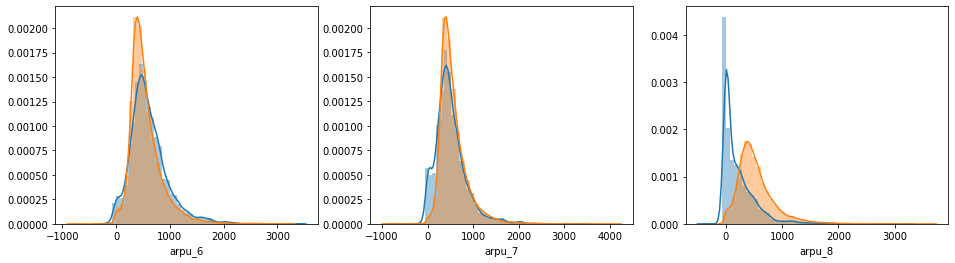

In [39]:
uni_dist('arpu_6', 'arpu_7', 'arpu_8',)

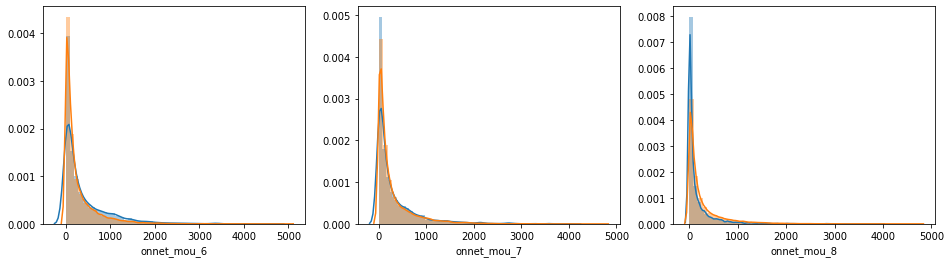

In [40]:
uni_dist('onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',)

Comparing the distribution of churn vs non-churn customers for 6,7 and 8 months.

#### vi. Bi-variate Analysis

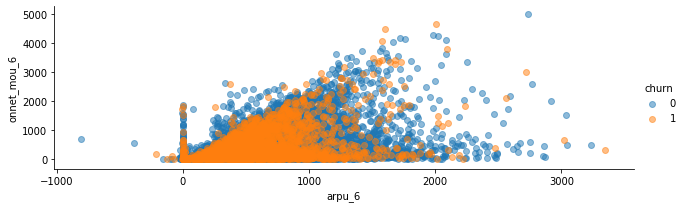

In [41]:
bivariate_plot("arpu_6","onnet_mou_6")

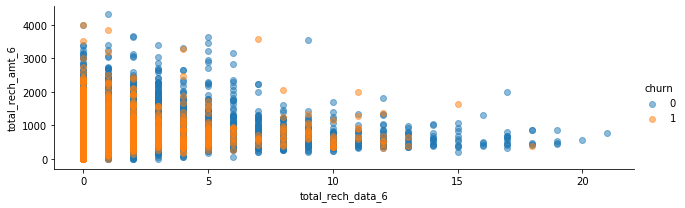

In [42]:
bivariate_plot("total_rech_data_6","total_rech_amt_6")

Observed the distribution of arpu_6 vs onnet_mou_6 and total_rech_data_6 vs total_rech_amt_6

### 3. Derive New Features

In [43]:
# See the vale in data frame churn_master
churn_master.describe()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,26654.000000,26654.000000,26654.000000,26654.000000,26654.000000,26654.00000,26654.000000,26654.000000,26654.000000,26654.000000,...,26654.000000,26654.000000,26654.000000,26654.000000,26654.000000,26654.000000,26654.000000,26654.000000,26654.000000,26654.000000
mean,292.496347,297.497736,263.565981,412.686041,417.441791,371.15951,14.374573,10.075070,10.251156,25.527814,...,0.159751,0.151985,0.090981,0.093757,0.086479,1271.179035,115.300289,118.607275,105.027754,4.167926
std,419.865360,427.815806,412.017107,437.617572,448.506426,427.38400,54.941389,43.803094,42.855948,89.363538,...,0.512617,0.501351,0.442481,0.467722,0.463813,975.314880,335.346283,342.207914,318.241567,24.613958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,44.260000,43.940000,32.310000,142.032500,139.530000,105.15000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,0.000000,0.000000,0.000000,0.000000
50%,130.425000,129.070000,105.635000,284.370000,284.135000,245.73500,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,925.500000,0.000000,0.000000,0.000000,0.000000
75%,360.125000,366.537500,307.570000,520.870000,530.437500,481.64250,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1939.000000,0.000000,0.000000,0.000000,0.000000
max,5012.190000,4730.640000,4744.480000,5081.010000,5194.830000,5184.11000,870.240000,681.080000,675.360000,1262.780000,...,5.000000,5.000000,7.000000,7.000000,7.000000,4321.000000,4238.540000,4384.060000,4001.000000,382.300000


In [44]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# In order to derive some features variables, we should first know how the varibales are corrleated.
cor_mat = churn_master.corr()
df_corr = cor_mat.stack().reset_index().sort_values(by = 0, ascending = False)

# Lets display only significant corrleation and not everything
df_corr = df_corr[((df_corr[0] < 1) & (df_corr[0] >= 0.6)) | ((df_corr[0] <= -0.6) & (df_corr[0] > -1))]

df_corr

,level_0,level_1,0
7345,loc_ic_mou_6,total_ic_mou_6,0.955105
11275,total_ic_mou_6,loc_ic_mou_6,0.955105
7478,loc_ic_mou_7,total_ic_mou_7,0.951323
11408,total_ic_mou_7,loc_ic_mou_7,0.951323
7611,loc_ic_mou_8,total_ic_mou_8,0.947459
11541,total_ic_mou_8,loc_ic_mou_8,0.947459
12357,total_rech_amt_8,arpu_8,0.941344
10785,arpu_8,total_rech_amt_8,0.941344
10519,arpu_6,total_rech_amt_6,0.922598
12091,total_rech_amt_6,arpu_6,0.922598


In [45]:
print(df_corr.shape)

(428, 3)


We can see that there are 524 columns whoich has very high correlation. The columns with same features have very high correlation with only month differing. Ex: arpu_2g_8	and arpu_3g_8. And 	total_ic_mou_7	loc_ic_mou_7. It can be handled in follwoing ways:
 - create a mean or avg. values for the last 3 months(jun,jul,aug)
 - for the recharge column, we can create mean, max, and min. value of last three months
    
Once we have all the necessary features, there is ***no need to drop the original columns*** because we will be using PCA, so importtant features can be highlighted yusing PCA.

In [46]:
# get the mean of onnet mou in the last 3 months
cols = ['onnet_mou_6','onnet_mou_7','onnet_mou_8']
churn_master['mean_onnet_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean of offnet mou in the last 3 months
cols = ['offnet_mou_6','offnet_mou_7','offnet_mou_8']
churn_master['mean_offnet_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean total of both onnet and offnet mou in the last 3 months
churn_master['mean_onnet_offnet_mou'] = churn_master['mean_onnet_mou'] + churn_master['mean_offnet_mou']

In [47]:
# Roaming columns
# get the mean of roam ic mou in the last 3 months
cols = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
churn_master['mean_roam_ic_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean of roam og mou in the last 3 months
cols = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8']
churn_master['mean_roam_og_mou'] = round(churn_master[cols].mean(axis=1),2)

# get the mean total of both roam ic and og mou in the last 3 months
churn_master['mean_roam_mou'] = churn_master['mean_roam_ic_mou'] + churn_master['mean_roam_og_mou']

In [48]:
# loc-t2t columns
cols = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8']
churn_master['mean_loc_ic_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8']
churn_master['mean_loc_og_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_t2t_mou'] = churn_master['mean_loc_ic_t2t_mou'] + churn_master['mean_loc_og_t2t_mou']

# loc-t2m columns
cols = ['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8']
churn_master['mean_loc_ic_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']
churn_master['mean_loc_og_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_t2m_mou'] = churn_master['mean_loc_ic_t2m_mou'] + churn_master['mean_loc_og_t2m_mou']

# loc-t2f columns
cols = ['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8']
churn_master['mean_loc_ic_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
churn_master['mean_loc_og_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_t2f_mou'] = churn_master['mean_loc_ic_t2f_mou'] + churn_master['mean_loc_og_t2f_mou']

# std-t2t columns
cols = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8']
churn_master['mean_std_ic_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8']
churn_master['mean_std_og_t2t_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_t2t_mou'] = churn_master['mean_std_ic_t2t_mou'] + churn_master['mean_std_og_t2t_mou']

# std-t2m columns
cols = ['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8']
churn_master['mean_std_ic_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8']
churn_master['mean_std_og_t2m_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_t2m_mou'] = churn_master['mean_std_ic_t2m_mou'] + churn_master['mean_std_og_t2m_mou']

# std-t2f columns
cols = ['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
churn_master['mean_std_ic_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
churn_master['mean_std_og_t2f_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_t2f_mou'] = churn_master['mean_std_ic_t2f_mou'] + churn_master['mean_std_og_t2f_mou']

In [49]:
cols = ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8']
churn_master['mean_loc_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8']
churn_master['mean_loc_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_loc_mou'] = churn_master['mean_loc_ic_mou'] + churn_master['mean_loc_og_mou']

# std columns
cols = ['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8']
churn_master['mean_std_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['std_og_mou_6','std_og_mou_7','std_og_mou_8']
churn_master['mean_std_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_std_mou'] = churn_master['mean_std_ic_mou'] + churn_master['mean_std_og_mou']

# isd columns
cols = ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8']
churn_master['mean_isd_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']
churn_master['mean_isd_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_isd_mou'] = churn_master['mean_isd_ic_mou'] + churn_master['mean_isd_og_mou']

# spl columns
cols = ['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8']
churn_master['mean_spl_ic_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8']
churn_master['mean_spl_og_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_spl_mou'] = churn_master['mean_spl_ic_mou'] + churn_master['mean_spl_og_mou']

# others columns
cols = ['ic_others_6','ic_others_7','ic_others_8']
churn_master['mean_ic_others_mou'] = round(churn_master[cols].mean(axis=1),2)
cols = ['og_others_6','og_others_7','og_others_8']
churn_master['mean_og_others_mou'] = round(churn_master[cols].mean(axis=1),2)

churn_master['mean_others_mou'] = churn_master['mean_ic_others_mou'] + churn_master['mean_og_others_mou']

In [50]:
### Features derivation for Reacharge columns

# total_rech_num columns
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
churn_master['mean_total_rech_num'] = round(churn_master[cols].mean(axis=1),2)     # mean
churn_master['min_total_rech_num'] = churn_master[cols].min(axis=1)                # Minimum
churn_master['max_total_rech_num'] = churn_master[cols].max(axis=1)                # Maximum

# total_rech_amt columns
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
churn_master['mean_total_rech_amt'] = round(churn_master[cols].mean(axis=1),2)
churn_master['min_total_rech_amt'] = churn_master[cols].min(axis=1)
churn_master['max_total_rech_amt'] = churn_master[cols].max(axis=1)

# max_rech_amt columns
cols = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
churn_master['mean_max_rech_amt'] = round(churn_master[cols].mean(axis=1),2)

# last_day_rch_amt columns
cols = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
churn_master['mean_last_day_rch_amt'] = round(churn_master[cols].mean(axis=1),2)


In [51]:
# To convert object type to numeric
churn_master['churn'] = churn_master['churn'].astype('int64')

#### Creating dummies

In [52]:
# To create dummies for categorical variables
churn_master=pd.get_dummies(churn_master, drop_first=True)

In [53]:
# Lets see the final shape of the df
print("The dimension of the churn_master is now:", churn_master.shape)

The dimension of the churn_master is now: (26654, 194)


In [54]:
# Lets make copy of the clean data for further analysis
final_df = churn_master.copy()
final_df.reset_index(inplace=True)
final_df.drop(['index'], axis = 1, inplace=True)
final_df.shape

(26654, 194)

In [55]:
# Final Check on null values - percentage of missing values present in each column.
mv2 = round(100*(final_df.isnull().sum(axis=0)/final_df.shape[0]), 2)
mv2.loc[mv2 > 0]

Series([], dtype: float64)

### Scaling the data before PCA

In [56]:
# To get the target variable
y = final_df.pop("churn")
y.head()

0    1
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

In [57]:
# To get the independent features
X = final_df.copy()
X.shape

(26654, 193)

In [58]:
# Collect numerical and cat variables 
num_col = X.columns[(X.dtypes=="float64")|(X.dtypes=="int64")].tolist()
print("No. of numerical var:",len(num_col))
cat_col = X.columns[(X.dtypes=="object")].tolist()
print("No. of Categorical var:",len(cat_col))
cat_col

No. of numerical var: 181
No. of Categorical var: 0


[]

In [59]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,test_size=0.3,random_state=40)
print("Shape of X_train is:", X_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of y_test is:", y_test.shape)

Shape of X_train is: (18657, 193)
Shape of X_test is: (7997, 193)
Shape of y_train is: (18657,)
Shape of y_test is: (7997,)


In [60]:
# Scaling numerical variable in this section
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Dimensionality reduction using PCA

In [61]:
from sklearn.decomposition import PCA
pca = PCA(random_state=100)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

In [62]:
pca.components_.round(2)

array([[-0.06, -0.06, -0.05, ...,  0.08, -0.01,  0.09],
       [ 0.11,  0.12,  0.12, ..., -0.06,  0.03, -0.05],
       [ 0.01,  0.03,  0.03, ...,  0.17, -0.01,  0.17],
       ...,
       [-0.  ,  0.  , -0.  , ...,  0.03, -0.  , -0.01],
       [-0.  ,  0.  ,  0.  , ..., -0.02, -0.  , -0.  ],
       [-0.  , -0.  ,  0.  , ...,  0.01, -0.01, -0.02]])

In [63]:
pca.explained_variance_ratio_.round(2)

array([0.12, 0.1 , 0.07, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

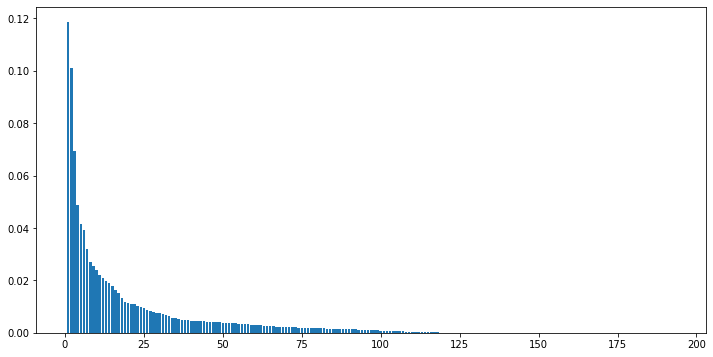

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.show()

In [65]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu.round(2)

array([0.12, 0.22, 0.29, 0.34, 0.38, 0.42, 0.45, 0.48, 0.5 , 0.53, 0.55,
       0.57, 0.59, 0.61, 0.63, 0.64, 0.66, 0.67, 0.68, 0.7 , 0.71, 0.72,
       0.73, 0.74, 0.75, 0.76, 0.76, 0.77, 0.78, 0.79, 0.79, 0.8 , 0.81,
       0.81, 0.82, 0.82, 0.83, 0.83, 0.84, 0.84, 0.85, 0.85, 0.86, 0.86,
       0.87, 0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.89, 0.9 , 0.9 , 0.9 ,
       0.91, 0.91, 0.91, 0.92, 0.92, 0.92, 0.93, 0.93, 0.93, 0.93, 0.94,
       0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.95, 0.95, 0.96, 0.96, 0.96,
       0.96, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98,
       0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.

In [66]:
# Before the Scree plot, lets see the value of variance at diff. no. of PCs
for i in range(40, len(var_cumu),10):
    print("Variance explained by ",i, " no. of PCs is:", sep = " ")
    print(var_cumu[i].round(2))

Variance explained by  40  no. of PCs is:
0.85
Variance explained by  50  no. of PCs is:
0.89
Variance explained by  60  no. of PCs is:
0.92
Variance explained by  70  no. of PCs is:
0.95
Variance explained by  80  no. of PCs is:
0.97
Variance explained by  90  no. of PCs is:
0.98
Variance explained by  100  no. of PCs is:
0.99
Variance explained by  110  no. of PCs is:
1.0
Variance explained by  120  no. of PCs is:
1.0
Variance explained by  130  no. of PCs is:
1.0
Variance explained by  140  no. of PCs is:
1.0
Variance explained by  150  no. of PCs is:
1.0
Variance explained by  160  no. of PCs is:
1.0
Variance explained by  170  no. of PCs is:
1.0
Variance explained by  180  no. of PCs is:
1.0
Variance explained by  190  no. of PCs is:
1.0


Plotting Scree plot see optimum number of PCs

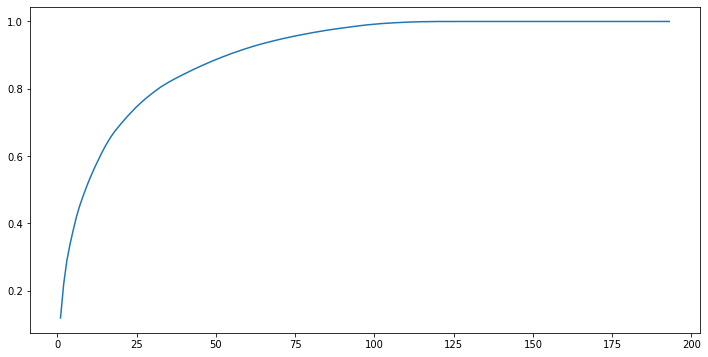

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,len(var_cumu)+1), var_cumu)
plt.show()

So, we can see that with 50 Components, we can explain 89% of the variance. And with 80 PCs, we can explain 97% of the variance.

In [68]:
colnames =X.columns
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df

,PC1,PC2,Feature
0,-0.055872,0.107218,onnet_mou_6
1,-0.059739,0.121957,onnet_mou_7
2,-0.049422,0.124638,onnet_mou_8
3,-0.001106,0.129557,offnet_mou_6
4,-0.005448,0.146774,offnet_mou_7
5,0.008536,0.146362,offnet_mou_8
6,-0.000238,0.008772,roam_ic_mou_6
7,-0.003983,-0.000172,roam_ic_mou_7
8,-0.002219,0.005417,roam_ic_mou_8
9,-0.014836,0.015260,roam_og_mou_6


In [69]:
# To use incremental PCA with 50 components
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=60)

In [70]:
df_train_pca = pca_final.fit_transform(X_train_scaled)
df_train_pca.shape

(18657, 60)

In [71]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

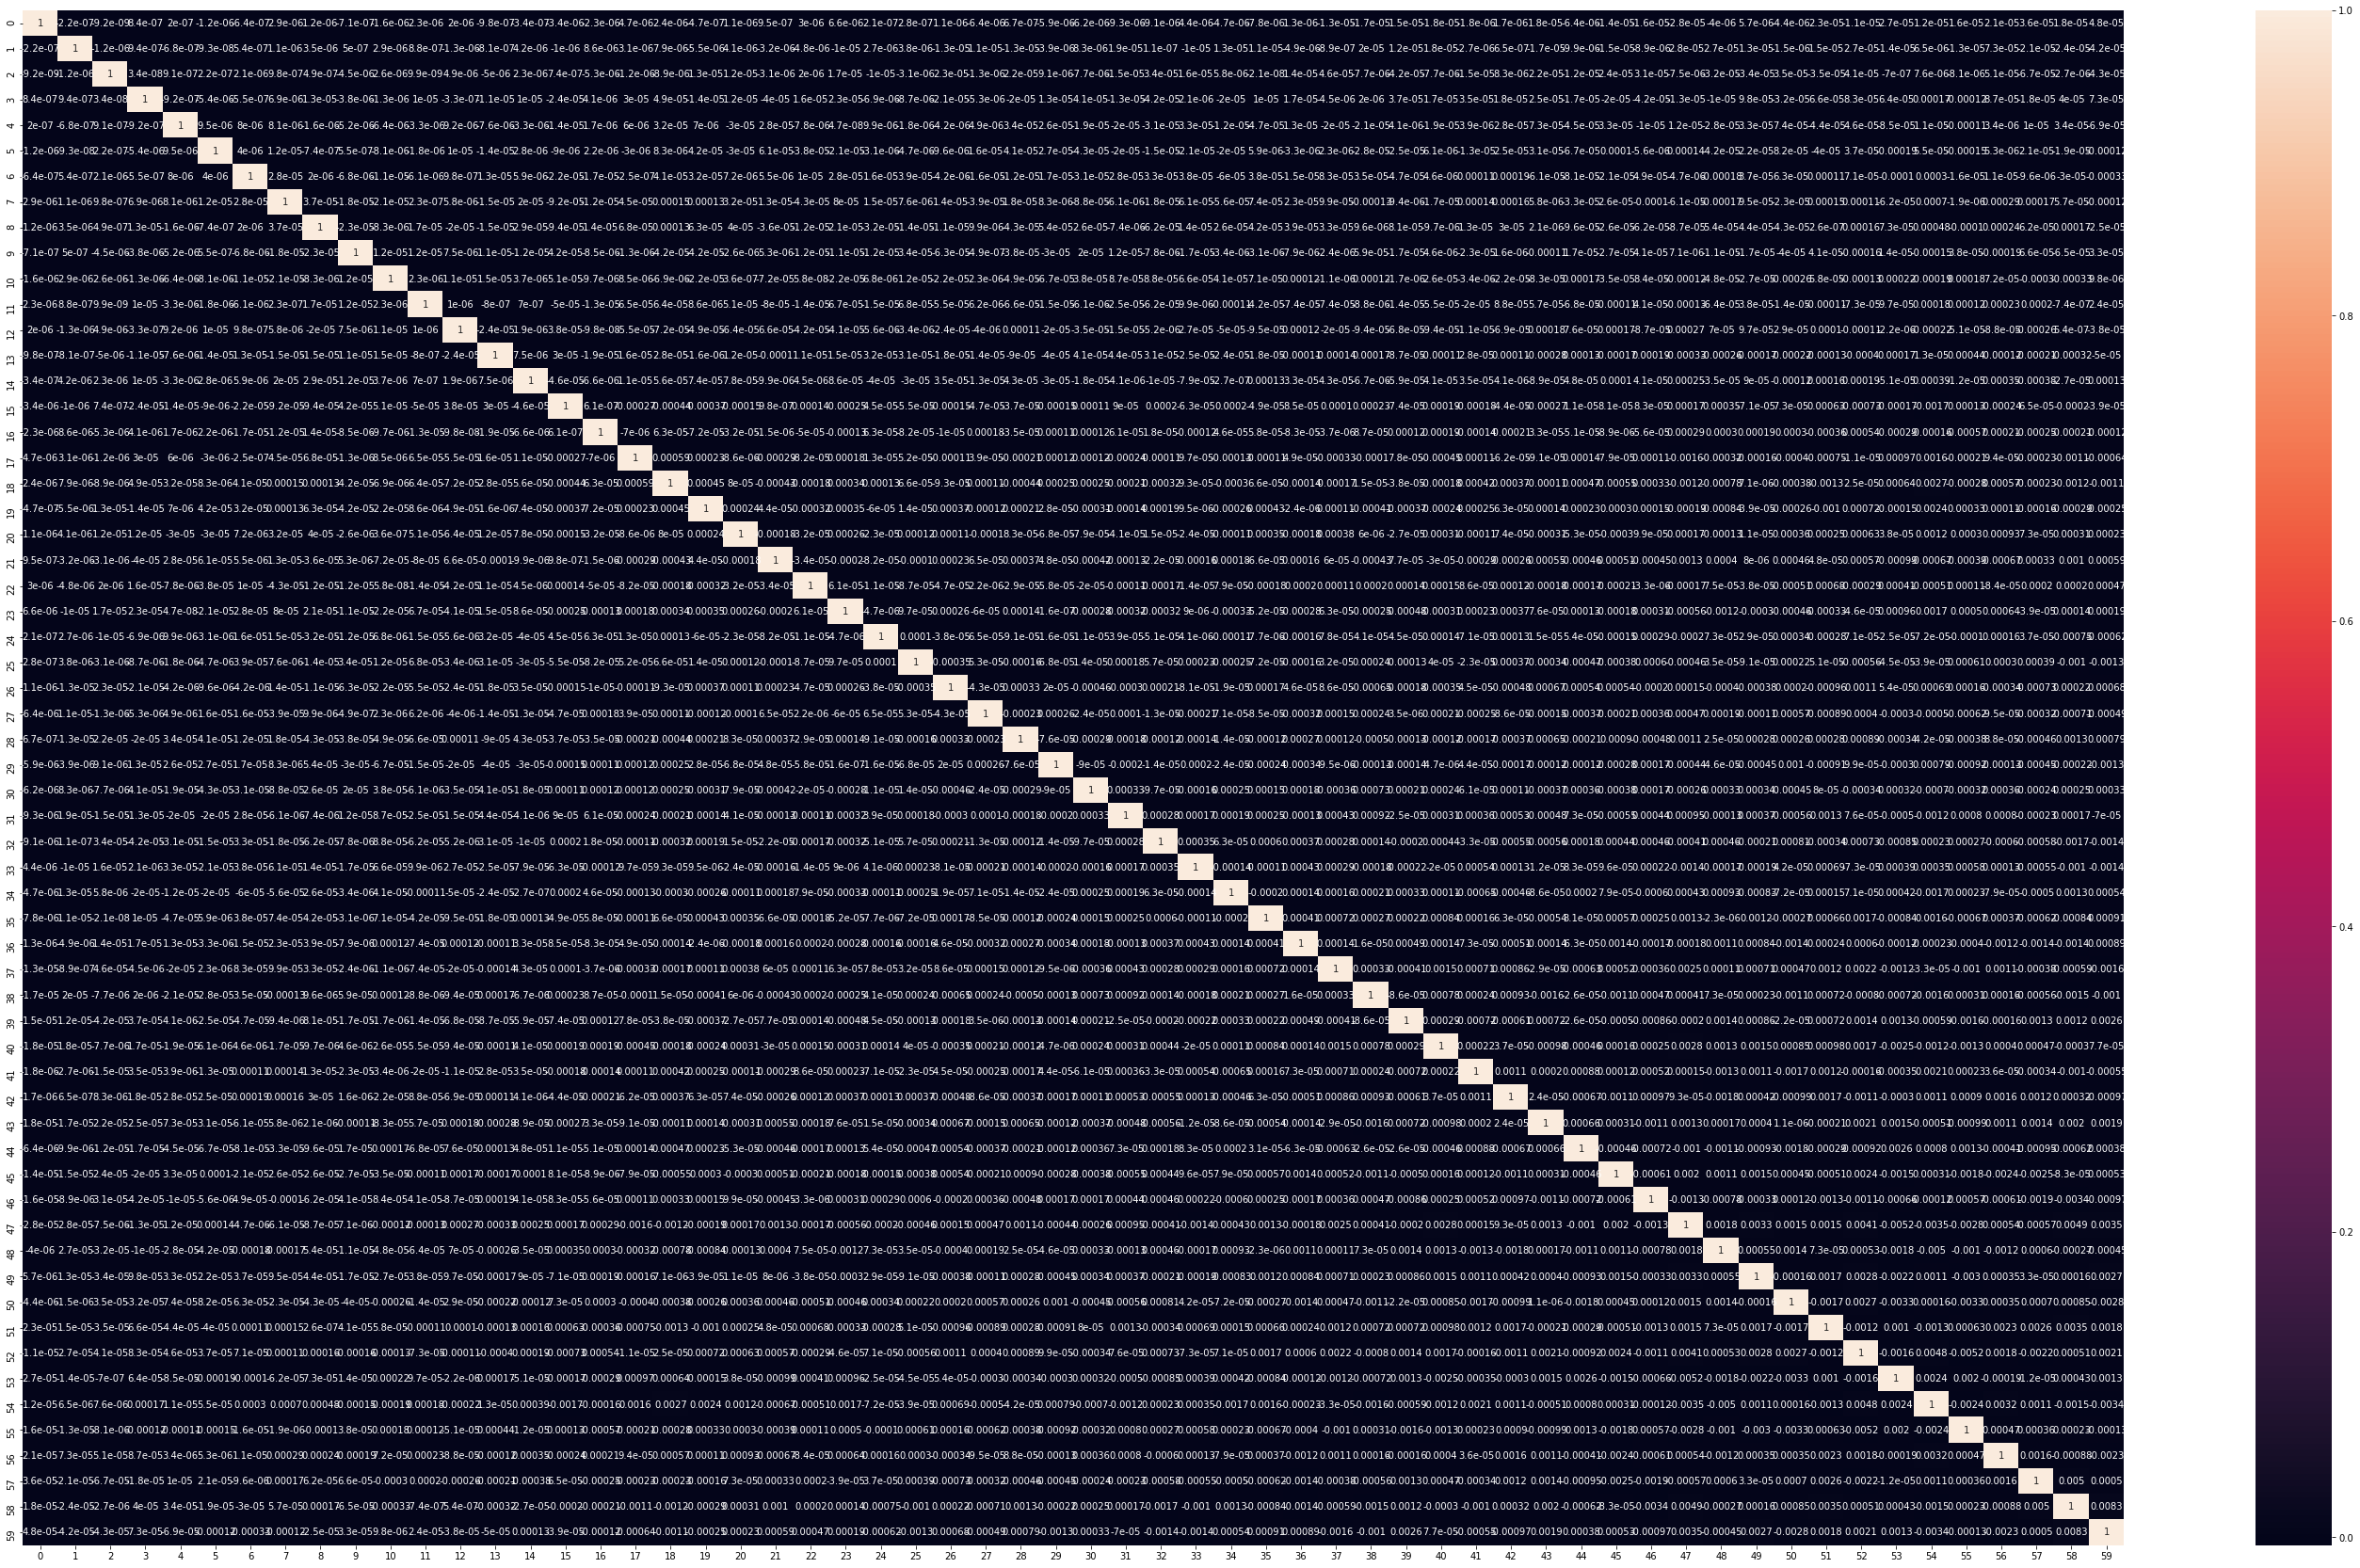

In [72]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (50,30))
sns.heatmap(corrmat,annot = True)
plt.show()

In [73]:
#Applying selected components to the test data
df_test_pca = pca_final.transform(X_test_scaled)
df_test_pca.shape


(7997, 60)

### 5. Training various Model

#### Logistic Regression

In [74]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

LR_model = LogisticRegression()
LRmodel_pca = LR_model.fit(df_train_pca, y_train)


In [75]:
y_pred_LR = LRmodel_pca.predict(df_test_pca)

In [76]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      7218
           1       0.66      0.30      0.41       779

    accuracy                           0.92      7997
   macro avg       0.79      0.64      0.68      7997
weighted avg       0.90      0.92      0.90      7997



In [77]:
# Evaluation on Test data
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

y_pred = LRmodel_pca.predict(df_test_pca)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))

# Could observe the logistic regression model is having low sensitivity or TPR value. So we should improve the model.


The Confusion Matrix for LR model is: [[7094  124]
 [ 543  236]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 0.3


It is worth noticing that for churn prediction, is is more important to identify churners than the non-churners accurately.
Thus, an evaluation metrics that focuses on the true churn prediction should be used as evalaution metrics. In this case, we
can use Sensitivity( or Recall) as evaluation metrics.

***Sensitivity (or Recall) = (True Positive)/(True Positive + False Negative)***

As we can observe, Sensitivity of the model is very low. So, We will try to address the class imbalance now.

In [78]:
# class imbalance - in the train data set
print(y_train.value_counts()/y_train.shape)
print(y_train.shape)
print(df_train_pca.shape)

0    0.901753
1    0.098247
Name: churn, dtype: float64
(18657,)
(18657, 60)


In [79]:
from imblearn.over_sampling import SMOTE

# To create SMOTE object and perform resampling
sm = SMOTE(random_state=40)
df_train_pca_res, y_train_res = sm.fit_resample(df_train_pca, y_train.ravel())

In [80]:
# class imbalance - in the train data set
print(df_train_pca_res.shape)
print(y_train_res.shape)

(33648, 60)
(33648,)


In [81]:
from sklearn.model_selection  import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
from sklearn.linear_model import LogisticRegressionCV

LR_CV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=skf
        ,random_state=40
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1
    
    )

In [82]:
LR_CV_model = LR_CV.fit(df_train_pca_res, y_train_res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


In [83]:
y_pred_LR_res = LR_CV_model.predict(df_test_pca)

In [84]:
print(classification_report(y_test, y_pred_LR_res))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7218
           1       0.34      0.83      0.49       779

    accuracy                           0.83      7997
   macro avg       0.66      0.83      0.69      7997
weighted avg       0.92      0.83      0.86      7997



In [85]:
# Evaluation on Test data

y_pred = LR_CV_model.predict(df_test_pca)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))


The Confusion Matrix for LR model is: [[5978 1240]
 [ 129  650]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 0.83


We can observe that ROC is unchanged while Sensitivity is increased to 83% now. 

#### SVM Model

In [86]:
# To import svm from sklearn and creat svm object
from sklearn import svm 
svm_linear = svm.SVC(kernel='linear')

In [87]:
# Train the svm model
st = time.time()
svm_linear_model = svm_linear.fit(df_train_pca_res, y_train_res)
et = time.time()
print("Time taken to train svm model :",et-st)

Time taken to train svm model : 1220.7904233932495


In [88]:
y_pred_svm = svm_linear_model.predict(df_test_pca)

In [89]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7218
           1       0.37      0.84      0.51       779

    accuracy                           0.84      7997
   macro avg       0.67      0.84      0.71      7997
weighted avg       0.92      0.84      0.87      7997



In [90]:
# Evaluation on Test data

y_pred = svm_linear_model.predict(df_test_pca)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))


The Confusion Matrix for LR model is: [[6094 1124]
 [ 121  658]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 0.84


**Observation**: SVM performance is 1% better than Logistic Regression. We alos observed that SVM model fitting is very time consuming and we could not finish the search of best parameter using GridSearch. So, finally we have taken out the cell. We will go ahead with this single model and try cretraing Random Forest next.

#### Random Forest

In [91]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# To create Random forest classifier with default paramters
rfc = RandomForestClassifier()

In [92]:
# To create balanced training samples
x_train_bal, y_train_bal = sm.fit_sample(X_train_scaled, y_train.ravel())

In [93]:
# fit
rfc_model = rfc.fit(x_train_bal, y_train_bal)

In [94]:
# To predict using rfc model
y_pred_rfc = rfc_model.predict(X_test_scaled)

In [95]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      7218
           1       0.59      0.67      0.63       779

    accuracy                           0.92      7997
   macro avg       0.78      0.81      0.79      7997
weighted avg       0.93      0.92      0.92      7997



In [96]:
# Evaluation on Test data
y_pred = rfc_model.predict(X_test_scaled)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))


The Confusion Matrix for LR model is: [[6851  367]
 [ 257  522]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 0.67


So, even this model needs improvement as Sensitivity is 66%

In [97]:
# RandomizedSearchCV to find optimal parameter values
from sklearn.model_selection import RandomizedSearchCV

# parameters to build the model on
param_grid = {"n_estimators": np.arange(20, 200, 20)
              ,"criterion": ["gini", "entropy"]
              ,"max_depth": np.arange(1, 28, 4)
              ,"min_samples_split": np.arange(1,150,2)
              ,"min_samples_leaf": np.arange(1,60,1)
              ,"max_leaf_nodes": np.arange(2,60,1)
             # ,"min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)
             }

# instantiate the randomforestclassifier
rf = RandomForestClassifier()


# to perform randomizedsearch
rf = RandomizedSearchCV(rf, param_grid, scoring="precision", n_iter = 100, 
                               verbose=2, random_state=40, n_jobs = -1)

In [98]:
rf.fit(x_train_bal, y_train_bal)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 54.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [99]:
print('The best hyper parameters for random forest are')
rf.best_params_

The best hyper parameters for random forest are


{'n_estimators': 160,
 'min_samples_split': 47,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 54,
 'max_depth': 13,
 'criterion': 'gini'}

In [100]:
# random forest model creation
rfc_best = RandomForestClassifier(n_estimators=160, 
                             max_depth=13,
                             min_samples_split=47,
                             min_samples_leaf=20,
                             max_leaf_nodes= 54,
                             max_features = 'auto',
                             bootstrap = True,
                             criterion='gini',
                             oob_score=True)

rfc_best.fit(x_train_bal, y_train_bal)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=54, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=47,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [101]:
#To predict using rfc model
y_pred_tuned_rfc=rfc_best.predict(X_test_scaled)

In [102]:
# Evaluation on Test data

y_pred = rfc_best.predict(X_test_scaled)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print("The Confusion Matrix for LR model is:",cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity = (True Positive)/(True Positive + False Negative): \t", round(sensitivity, 2))


The Confusion Matrix for LR model is: [[6543  675]
 [ 172  607]]
Sensitivity = (True Positive)/(True Positive + False Negative): 	 0.78


**Conclusion:** In case of RF, we got the Sensitivity as 78% whereas in SVM model, the sensitivity was 84%. So, SVM is the best model for this case. Now, we will build the final model as SVM model with PCA component. 

### Suggesting ways to reducce customer churn - Deducing Top 30 Features

- we will use Random Forest Model on actual X_train and X_test data to derive top features

In [103]:
# No. of Features in X_train df
print("No. of attributes in X_train:", X_train.shape[1])

# top features Consideration
# As we are building the RF model, we can fix the no. of features for each nodes for split so that we can derive the top 
# features

max_features = int(round(np.sqrt(X_train.shape[1])))
print("max_features:", max_features)


No. of attributes in X_train: 193
max_features: 14


In [104]:
# fit the model
rf_features_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, 
                                  oob_score=True, random_state=4, verbose=1)


In [105]:
# fit model
rf_features_model = rf_features_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished


In [106]:
# Out of the Bag score
rf_features_model.oob_score_

0.9257115291847564

In [107]:
# Deriving the top features now
# predictors
features = churn_master.drop('churn', axis=1).columns

# feature_importance
importance = rf_features_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': (importance*100).round(2)})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", int(feature_importance.importance_percentage.sum()))
feature_importance

Sum of importance= 100


,variables,importance_percentage
0,total_ic_mou_8,7.69
1,total_og_mou_8,4.97
2,min_total_rech_amt,4.44
3,total_rech_amt_8,4.27
4,arpu_8,3.22
5,last_day_rch_amt_8,3.10
6,max_rech_amt_8,2.63
7,roam_ic_mou_8,2.35
8,roam_og_mou_8,2.26
9,loc_og_mou_8,1.96


#### Extract Top 20 Features Now

In [108]:
# extract top 20 features
top_n = 20
top20 = feature_importance.head(top_n)
top20

,variables,importance_percentage
0,total_ic_mou_8,7.69
1,total_og_mou_8,4.97
2,min_total_rech_amt,4.44
3,total_rech_amt_8,4.27
4,arpu_8,3.22
5,last_day_rch_amt_8,3.10
6,max_rech_amt_8,2.63
7,roam_ic_mou_8,2.35
8,roam_og_mou_8,2.26
9,loc_og_mou_8,1.96


<Figure size 576x576 with 0 Axes>

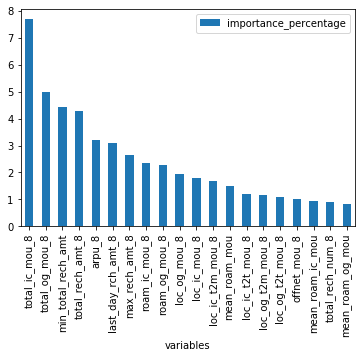

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
top20.plot(kind='bar',x='variables',y='importance_percentage')
plt.show()

### Recommend strategies to manage Business Churn:

• We can see that some of the top important features is related to Roaming call and T2M, So company should think about having a   reasonable call rate for roaming services and call made to other operator.

• Company should also pay attention to the incoming and outgoing calls usage and hence total recharge and average revenue for the customer. If they tend to drop, then its a very strong indication that customer might churn in near future.
